# 1. Loading Dataset 

In [3]:
import arff
import numpy as np
import pandas as pd
import numpy as np    
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
import seaborn as sns

In [4]:
def readDatabaseFile(filePath):
    # read csv data
    with open(filePath) as f:
        # load reads the csv db as a dictionary with
        # the data as a list of lists at key "data"
        dataFrame = pd.read_csv(f)
        f.close()

    return dataFrame

In [195]:
def read_data_return_frame(filename):
    
    df = readDatabaseFile(filename)
    
    #drop the columns that asuuming has less value for prediction
    df = df.drop(df.columns[[0,1,2,3,8,11,12,14]], axis=1)

    #get average of product realted and duration and drop product related visited page amount
    df['ProductRelatedAve'] = df.apply(lambda row: row.ProductRelated_Duration / row.ProductRelated if row.ProductRelated else 0, axis=1)
    new_coloumn_order = list(df.columns)
    new_coloumn_order.insert(2,'ProductRelatedAve')
    new_coloumn_order.pop()
    df = df.reindex(columns = new_coloumn_order)
    df = df.drop(df.columns[[0]], axis=1)

    return df

data_frame_os = read_data_return_frame("online_shoppers_intention.csv")

# 2. Exploration of Dataset

The dataset consists of 10 numerical and 8 categorical attributes. Of which, 9 relevant attributes have been selected (5 numerical and 4 categorical).

The 'Revenue' attribute is the class label.

Description of Dataset. (Taken from UCI repository, those in bold are the selected attributes)

"**Product Related**" and "**Product Related Duration**" represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories. The values of these features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. 

The "**Bounce Rate**" and "**Exit Rate**" features represent the metrics measured by "Google Analytics" for each page in the e-commerce site. The value of "Bounce Rate" feature for a web page refers to the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session. The value of "Exit Rate" feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session. 

The "**Special Day**" feature indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentine’s day, this value takes a nonzero value between February 2 and February 12, zero before and after this date unless it is close to another special day, and its maximum value of 1 on February 8. 

The dataset also includes **region**, **visitor type** as returning or new visitor, a Boolean value indicating whether the date of the visit is **weekend**, and **month** of the year.

In [196]:
data_frame_os

,ProductRelated_Duration,ProductRelatedAve,BounceRates,ExitRates,SpecialDay,Month,Region,VisitorType,Weekend,Revenue
0,0.000000,0.000000,0.200000,0.200000,0.0,Feb,1,Returning_Visitor,False,False
1,64.000000,32.000000,0.000000,0.100000,0.0,Feb,1,Returning_Visitor,False,False
2,0.000000,0.000000,0.200000,0.200000,0.0,Feb,9,Returning_Visitor,False,False
3,2.666667,1.333333,0.050000,0.140000,0.0,Feb,2,Returning_Visitor,False,False
4,627.500000,62.750000,0.020000,0.050000,0.0,Feb,1,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...
12325,1783.791667,33.656447,0.007143,0.029031,0.0,Dec,1,Returning_Visitor,True,False
12326,465.750000,93.150000,0.000000,0.021333,0.0,Nov,1,Returning_Visitor,True,False
12327,184.250000,30.708333,0.083333,0.086667,0.0,Nov,1,Returning_Visitor,True,False
12328,346.000000,23.066667,0.000000,0.021053,0.0,Nov,3,Returning_Visitor,False,False


### Conversion of numerical variables to categorical 

function preprocess_df() factorizes the categorical data 

function convert_num_to_cat() converts the numerical data into categorical

In [197]:
def preprocess_df(df):       

    #pre_processing month column into categorical attribute with one hot encoding
    # ohe = preprocessing.OneHotEncoder()
    # columnTransformer = ColumnTransformer([('encoder', ohe, [5,6])], remainder='passthrough')
    # df = np.array(columnTransformer.fit_transform(df), dtype = np.str)

    #factorize categorical attributes
    df['Month'] = pd.factorize(df.Month)[0]
    df['VisitorType'] = pd.factorize(df.VisitorType)[0]  
    df['Weekend'] = pd.factorize(df.Weekend)[0]  

In [198]:
def convert_num_to_cat(df):
    
    # SpecialDay column is actually split into 6 categories (0,0.2,0.4,0.6,0.8,1), so we just
    # multiply to get it to become an integer
    df['SpecialDay'] = 5 * df['SpecialDay']
    df['SpecialDay'] = df['SpecialDay'].astype('int64')
    
    # Product Related Duration, Product Related Average and Exit Rates binned into 5 
    # categories (0-4) based on quantiles
    df['ProductRelated_Duration'] = pd.qcut(df['ProductRelated_Duration'], 5, labels=[0, 1, 2, 3, 4])
    df['ProductRelatedAve'] = pd.qcut(df['ProductRelatedAve'], 5, labels=[0, 1, 2, 3, 4])
    df['ExitRates'] = pd.qcut(df['ExitRates'], 5, labels=[0, 1, 2, 3, 4])
    
    # BounceRates binned into 3 categories based on quantiles (0-2) as there are 
    # duplicate bins (of 0s) due to too many occurences 
    df['BounceRates'] = pd.qcut(df['BounceRates'], 5, duplicates = 'drop', labels=[0, 1, 2])

In [199]:
data_frame_os_cat = data_frame_os.copy()
convert_num_to_cat(data_frame_os_cat)
data_frame_os_cat

,ProductRelated_Duration,ProductRelatedAve,BounceRates,ExitRates,SpecialDay,Month,Region,VisitorType,Weekend,Revenue
0,0,0,2,4,0,0,1,0,0,False
1,0,2,0,4,0,0,1,0,0,False
2,0,0,2,4,0,0,9,0,0,False
3,0,0,2,4,0,0,2,0,0,False
4,2,4,1,3,0,0,1,0,1,False
...,...,...,...,...,...,...,...,...,...,...
12325,4,2,0,2,0,9,1,0,1,False
12326,2,4,0,2,0,7,1,0,1,False
12327,1,2,2,4,0,7,1,0,1,False
12328,1,1,0,2,0,7,3,0,0,False


### 2.2 Exploration of numerical attributes

In [178]:
data_frame_os.iloc[:,:5].describe()

,ProductRelated_Duration,ProductRelatedAve,BounceRates,ExitRates,SpecialDay
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,1194.746220,37.633690,0.022191,0.043073,0.061427
std,1913.669288,44.767916,0.048488,0.048597,0.198917
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,184.137500,17.613281,0.000000,0.014286,0.000000
50%,598.936905,28.878189,0.003112,0.025156,0.000000
75%,1464.157213,45.084444,0.016813,0.050000,0.000000
max,63973.522230,1411.000000,0.200000,0.200000,1.000000


### 2.1 Exploration of categorical attributes 

This subsection illustrates how the categorical attributes have been factorized and their distribution 

In [289]:
dz = read_data_return_frame("online_shoppers_intention.csv") 
for indx, var in enumerate(data_frame_os.columns.tolist()):
    print('----------------')
    if var not in ('ProductRelated_Duration', 'ProductRelatedAve', 'BounceRates', 'ExitRates', 'SpecialDay'):
        print('Pre-encoded attributes:', dz[var].unique())
    print(var)
    print(data_frame_os_cat[var].unique())
    print('Counts by', var)
    print(data_frame_os[var].value_counts())

----------------
ProductRelated_Duration
[0, 2, 1, 3, 4]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]
Counts by ProductRelated_Duration
0.000000       755
17.000000       21
8.000000        17
11.000000       17
15.000000       16
              ... 
6560.007540      1
821.893333       1
2004.500000      1
266.500000       1
1919.550000      1
Name: ProductRelated_Duration, Length: 9551, dtype: int64
----------------
ProductRelatedAve
[0, 2, 4, 1, 3]
Categories (5, int64): [0 < 1 < 2 < 3 < 4]
Counts by ProductRelatedAve
0.000000      755
6.000000       18
8.000000       17
10.000000      16
11.000000      16
             ... 
54.677800       1
17.733333       1
22.745833       1
71.691176       1
100.000000      1
Name: ProductRelatedAve, Length: 10313, dtype: int64
----------------
BounceRates
[2, 0, 1]
Categories (3, int64): [0 < 1 < 2]
Counts by BounceRates
0.000000    5518
0.200000     700
0.066667     134
0.028571     115
0.050000     113
            ... 
0.023457       1
0.003901   

In [200]:
# Plot for dataframe where all attributes have been categorised

def count_plot(df, columns):
    plt.figure(figsize=(15, 10))
    for indx, var  in enumerate(columns):
        plt.subplot(3, 3, indx+1)
        g = sns.countplot(df[var], hue= df['Revenue'])
    plt.tight_layout()

features = data_frame_os.columns.tolist()
features.remove('Revenue')
features

['ProductRelated_Duration',
 'ProductRelatedAve',
 'BounceRates',
 'ExitRates',
 'SpecialDay',
 'Month',
 'Region',
 'VisitorType',
 'Weekend']

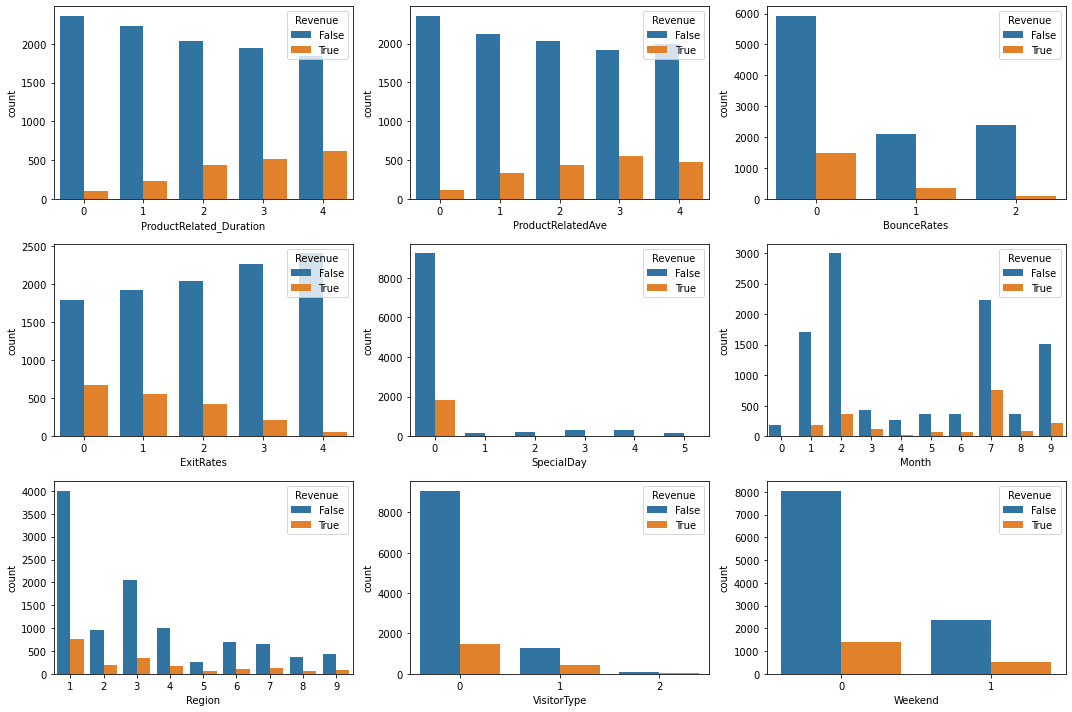

In [220]:
import warnings
warnings.filterwarnings('ignore')
count_plot(data_frame_os_cat, features)

In [229]:
df_minus_rev = data_frame_os_cat[features]

df_minus_rev

,ProductRelated_Duration,ProductRelatedAve,BounceRates,ExitRates,SpecialDay,Month,Region,VisitorType,Weekend
0,0,0,2,4,0,0,1,0,0
1,0,2,0,4,0,0,1,0,0
2,0,0,2,4,0,0,9,0,0
3,0,0,2,4,0,0,2,0,0
4,2,4,1,3,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
12325,4,2,0,2,0,9,1,0,1
12326,2,4,0,2,0,7,1,0,1
12327,1,2,2,4,0,7,1,0,1
12328,1,1,0,2,0,7,3,0,0


In [230]:
# Value of 1 means no correlation, values >4-5 usually viewed as moderate to high. This is to check if the naive
# assumption is likely to hold/be correct, or will cause problems

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(df_minus_rev.values, i) for i in range(len(features))]
vif["Features"] = features
vif 


,VIF,Features
0,5.646041,ProductRelated_Duration
1,5.335278,ProductRelatedAve
2,2.716612,BounceRates
3,4.513347,ExitRates
4,1.197827,SpecialDay
5,3.335315,Month
6,2.444946,Region
7,1.276248,VisitorType
8,1.271668,Weekend


# 3. Preparing Algorithms

In [435]:
import sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from mixed_naive_bayes import MixedNB
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from statistics import *
from sklearn.utils import resample
from sklearn.inspection import permutation_importance

In [221]:
def xy_split(df):
    #return all column except last one for arttributes
    x = df.iloc[:,0: -1:1].values

    #return last column for label revenue true(1) / false(0)
    y = df.iloc[:, -1]
    y,class_names = pd.factorize(y)
    class_names = [str(x) for x in class_names]

    #get feature names
    feature_names = list(df.columns)[:-1]
        
    return x, y, class_names, feature_names

In [311]:
def train_test_classifier(x, y, test_size=0.25, classifier="Multinomial"):
    
    # split into train/test sets with same class ratio
    x_train, x_test, y_train, y_test = \
        model_selection.train_test_split(x, y, test_size=test_size, stratify=y, random_state=42)
    
    param_grid = [{'alpha': [0.1,0.5, 1.0, 1.5, 5, 10]}]
     
    if classifier in ('Gaussian','Categorical'):      
        
        if classifier == 'Gaussian':
            classifier = GaussianNB()
            classifier.fit(x_train, y_train)
            print('Classes: ', classifier.classes_)
            print('Class Priors: ',classifier.class_prior_)        
        elif classifier == "Categorical":
            classifier = CategoricalNB()
            classifier.fit(x_train, y_train)
            print('Classes: ', classifier.classes_)
            print('Class Log Priors: ',classifier.class_log_prior_)
    else:
        if classifier == "Multinomial":
            classifier = MultinomialNB()
        elif classifier == "Complement":
            classifier = ComplementNB() 
        elif classifier == "Bernoulli":
            classifier = BernoulliNB()

        grid_search = GridSearchCV(classifier, param_grid, cv=5, verbose=2, scoring = 'f1_macro')
        grid_search.fit(x_train, y_train)   
        classifier = grid_search.best_estimator_
        print(classifier)
        classifier.fit(x_train, y_train)
        print('Classes: ', classifier.classes_)
        print('Class Log Priors: ',classifier.class_log_prior_)
    return x_train, x_test, y_train, y_test, classifier

In [223]:
def prediction(classifier, x):
    # Model prediction on given set
    # y_pred = classifier.predict(x)
    y_pred = classifier.predict(x)
    return y_pred

In [393]:
def f1_kappa_cm_report(y, y_pred, class_names=[]):

    f1score = sklearn.metrics.f1_score(y, y_pred, average = 'macro')
    print("F1 Score: {:.2f}".format(f1score))
    
    kappa = sklearn.metrics.cohen_kappa_score(y, y_pred)
    print("Kappa Score: {:.2f}".format(kappa))

    cm = sklearn.metrics.confusion_matrix(y, y_pred)
    print(sklearn.metrics.classification_report(y, y_pred, target_names=class_names))
    
    print('Confusion Matrix: \n', cm)
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, cmap = "BuPu",
                ax=ax)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    
    return f1score, kappa

# 4. Results

### 4.1 CategoricalNB Approach

In [462]:
x, y, class_names, feature_names = xy_split(data_frame_os_cat)

Classes:  [0 1]
Class Log Priors:  [-0.16812626 -1.86592567]
--------------------------------------------------------
Report for Training
F1 Score: 0.63
Kappa Score: 0.26
              precision    recall  f1-score   support

       False       0.88      0.88      0.88      7816
        True       0.37      0.37      0.37      1431

    accuracy                           0.81      9247
   macro avg       0.63      0.63      0.63      9247
weighted avg       0.81      0.81      0.81      9247

Confusion Matrix: 
 [[6917  899]
 [ 901  530]]
--------------------------------------------------------
Report for Testing
F1 Score: 0.62
Kappa Score: 0.25
              precision    recall  f1-score   support

       False       0.88      0.89      0.89      2606
        True       0.37      0.35      0.36       477

    accuracy                           0.81      3083
   macro avg       0.63      0.62      0.62      3083
weighted avg       0.80      0.81      0.81      3083

Confusion Matrix: 


(0.6244597002895362, 0.24905893436443916)

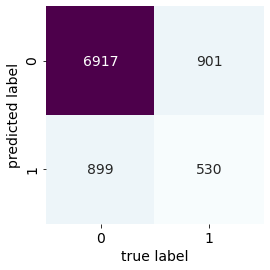

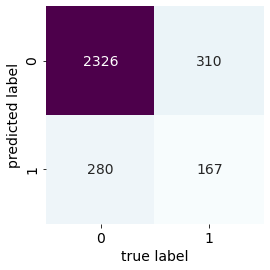

In [463]:
x_train, x_test, y_train, y_test, classifier = train_test_classifier(x, y, test_size=0.25, classifier="Categorical")
print('--------------------------------------------------------')
print("Report for Training")
y_pred_train = prediction(classifier, x_train)
f1_kappa_cm_report(y_train, y_pred_train, class_names=class_names)
print('--------------------------------------------------------')
print("Report for Testing")
y_pred_test = prediction(classifier, x_test)
f1_kappa_cm_report(y_test, y_pred_test, class_names=class_names)

Feature ranking:
1. Month (0.004109)
2. VisitorType (0.001719)
3. Weekend (0.000865)
4. Region (-0.000173)
5. SpecialDay (-0.003926)
6. ProductRelated_Duration (-0.004921)
7. ProductRelatedAve (-0.006608)
8. BounceRates (-0.008414)
9. ExitRates (-0.008684)


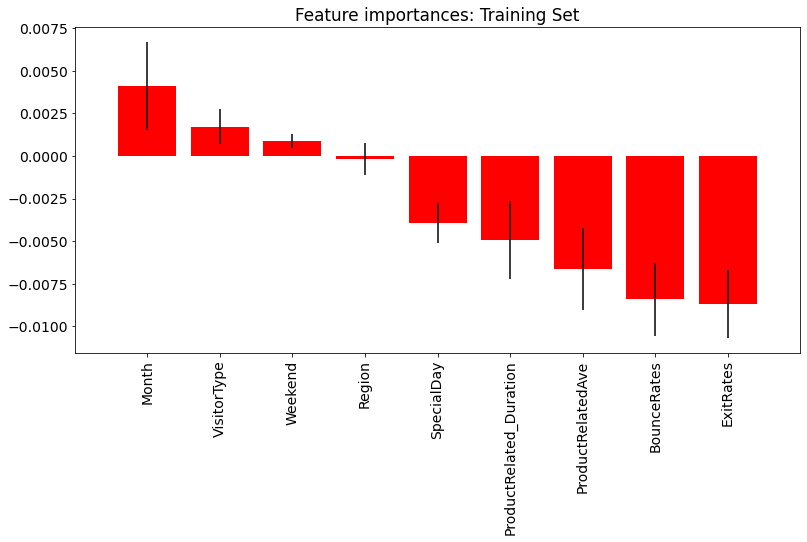

In [459]:
imps = permutation_importance(classifier, x_train, y_train, n_repeats = 10)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(x_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(13, 6))
plt.title("Feature importances: Training Set")
plt.bar(range(x_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), [features[indices[i]] for i in range(9)], rotation='vertical')
plt.xlim([-1, x_train.shape[1]])
plt.show()

Feature ranking:
1. Month (0.015504)
2. VisitorType (0.002465)
3. Region (0.001362)
4. Weekend (-0.002400)
5. SpecialDay (-0.003049)
6. ProductRelated_Duration (-0.004249)
7. BounceRates (-0.006682)
8. ExitRates (-0.007071)
9. ProductRelatedAve (-0.008174)


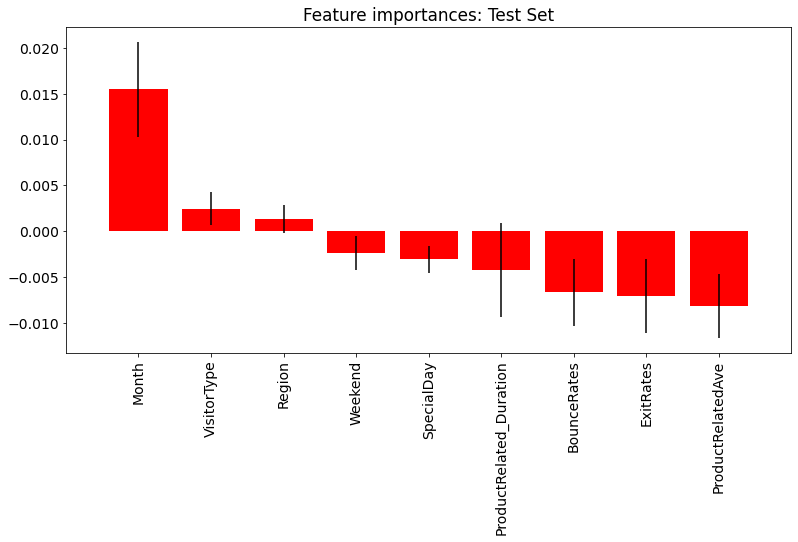

In [460]:
imps = permutation_importance(classifier, x_test, y_test, n_repeats = 10)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(x_test.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))
    
plt.figure(figsize=(13, 6))
plt.title("Feature importances: Test Set")
plt.bar(range(x_test.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_test.shape[1]), [features[indices[i]] for i in range(9)], rotation='vertical')
plt.xlim([-1, x_test.shape[1]])
plt.show()

#### Stratified K Fold cross validation 

Fold 1  train -  [8337 1527]   |   test -  [2085  381] 

Test Result 

F1 Score: 0.47
Kappa Score: 0.03
              precision    recall  f1-score   support

       False       0.86      0.59      0.70      2085
        True       0.17      0.46      0.25       381

    accuracy                           0.57      2466
   macro avg       0.51      0.52      0.47      2466
weighted avg       0.75      0.57      0.63      2466

Confusion Matrix: 
 [[1227  858]
 [ 206  175]]
--------------------------------------------------------
Fold 2  train -  [8337 1527]   |   test -  [2085  381] 

Test Result 

F1 Score: 0.55
Kappa Score: 0.12
              precision    recall  f1-score   support

       False       0.86      0.94      0.90      2085
        True       0.32      0.15      0.21       381

    accuracy                           0.82      2466
   macro avg       0.59      0.55      0.55      2466
weighted avg       0.77      0.82      0.79      2466

Confusion Matrix: 
 [[1957  128]
 

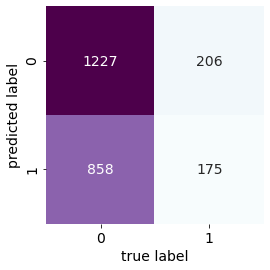

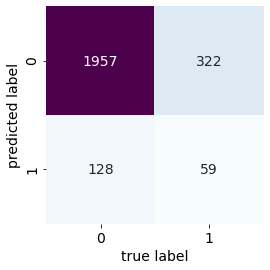

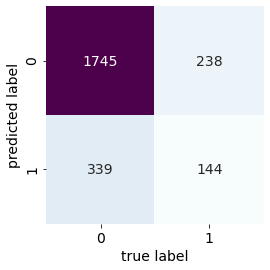

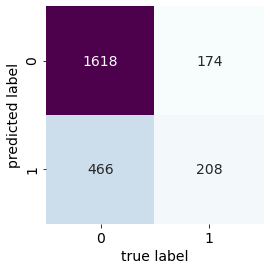

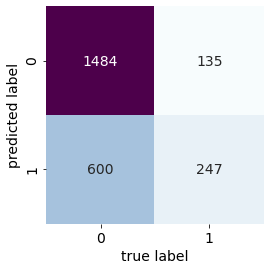

In [354]:
skf = StratifiedKFold(n_splits=5)
fold = 1 

lst_f1_stratified = [] 
lst_kappa_stratified = [] 

for train, test in skf.split(x, y):
    print('Fold {}  train -  {}   |   test -  {} \n'.format(
            fold, np.bincount(y[train]), np.bincount(y[test])))
    fold +=1
    print('Test Result \n')
    x_train, x_test= x[train], x[test]
    y_train, y_test= y[train], y[test]
    
    classifier.fit(x_train,y_train)
    y_pred_test = classifier.predict(x_test)

    f1score, kappa = f1_kappa_cm_report(y_test, y_pred_test, class_names = class_names)
    lst_f1_stratified.append(f1score)
    lst_kappa_stratified.append(kappa)
    print('--------------------------------------------------------')

In [360]:
# Print the output. 
print('List of possible f1 scores: \n', lst_f1_stratified) 
print('\nMaximum f1 score That can be obtained from this model is:', 
      max(lst_f1_stratified)*100, '%') 
print('\nMinimum f1 score:', 
      min(lst_f1_stratified)*100, '%') 
print('\nOverall f1 score:', 
      mean(lst_f1_stratified)*100, '%') 
print('\nStandard Deviation is:', stdev(lst_f1_stratified)) 
print('----------------------------------')
print('List of possible kappa scores: \n', lst_kappa_stratified) 
print('\nMaximum kappa scores That can be obtained from this model is:', 
      max(lst_kappa_stratified)*100, '%') 
print('\nMinimum kappa score:', 
      min(lst_kappa_stratified)*100, '%') 
print('\nOverall kappa score:', 
      mean(lst_kappa_stratified)*100, '%') 
print('\nStandard Deviation is:', stdev(lst_kappa_stratified)) 

List of possible f1 scores: 
 [0.472540090848198, 0.5523150359535767, 0.5955371799809832, 0.6144103574444131, 0.6017325472474433]

Maximum f1 score That can be obtained from this model is: 61.44103574444131 %

Minimum f1 score: 47.2540090848198 %

Overall f1 score: 56.73070422949229 %

Standard Deviation is: 0.057892818431406076
----------------------------------
List of possible kappa scores: 
 [0.02813342430377619, 0.11802154516712038, 0.19341321642240306, 0.24455762124490232, 0.23959328848811412]

Maximum kappa scores That can be obtained from this model is: 24.45576212449023 %

Minimum kappa score: 2.813342430377619 %

Overall kappa score: 16.47438191252632 %

Standard Deviation is: 0.09170604024705356


#### ROC AUC Curve & PR Curve

In [295]:
# retrieve just the probabilities for the positive class
y_prob_categorical = classifier.predict_proba(x_test)[:,1]

roc auc score: 0.7340024069595885


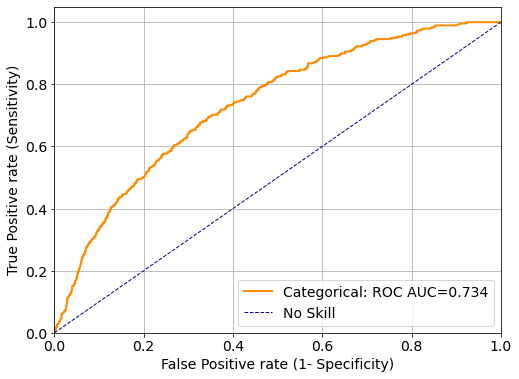

In [312]:
def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel(), average = 'macro')
    return fpr, tpr, roc_auc

print('roc auc score:', roc_auc)

plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_prob_categorical)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='Categorical: ROC AUC={0:.3f}'.format(roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label = 'No Skill')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive rate (1- Specificity)')
plt.ylabel('True Positive rate (Sensitivity)')
plt.show()

PR AUC: 0.318


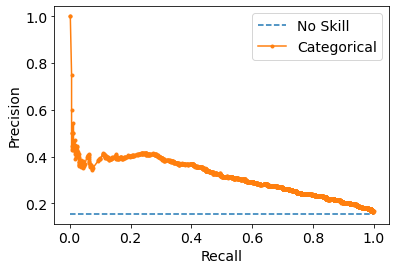

In [464]:
# plot no skill and model precision-recall curves
def plot_pr_curve(y_test, model_probs):
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y_test[y_test==1]) / len(y_test)
    # plot the no skill precision-recall curve
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    pyplot.plot(recall, precision, marker='.', label='Categorical')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

precision, recall, _ = precision_recall_curve(y_test, y_prob_categorical)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)
plot_pr_curve(y_test, y_prob_categorical)

#### Resampling (Oversampling & Undersampling)

In [430]:
# Separate input features and target
y = data_frame_os_cat.Revenue
y, class_names = pd.factorize(y)
y= pd.DataFrame({'Revenue':y}) 
x = data_frame_os_cat.drop('Revenue', axis=1)

# setting up testing and training sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, random_state=43)

# concatenate our training data back together
X = pd.concat([x_train, y_train], axis=1)

# separate minority and majority classes
not_true = X[X.Revenue==0]
true = X[X.Revenue==1]

# upsample minority
true_upsampled = resample(true,
                          replace=True, # sample with replacement
                          n_samples=len(not_true), # match number in majority class
                          random_state=43) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_true, true_upsampled])

# check new class counts
upsampled.Revenue.value_counts()

1    7817
0    7817
Name: Revenue, dtype: int64

Report for Training Set
F1 Score: 0.67
Kappa Score: 0.35
              precision    recall  f1-score   support

           0       0.74      0.55      0.63      7817
           1       0.64      0.80      0.71      7817

    accuracy                           0.68     15634
   macro avg       0.69      0.68      0.67     15634
weighted avg       0.69      0.68      0.67     15634

Confusion Matrix: 
 [[4280 3537]
 [1526 6291]]
--------------------------------------------------------
Report for Test Set
F1 Score: 0.55
Kappa Score: 0.20
              precision    recall  f1-score   support

           0       0.95      0.56      0.70      2605
           1       0.26      0.82      0.39       478

    accuracy                           0.60      3083
   macro avg       0.60      0.69      0.55      3083
weighted avg       0.84      0.60      0.66      3083

Confusion Matrix: 
 [[1461 1144]
 [  85  393]]


(0.5470006031611863, 0.2011156528964616)

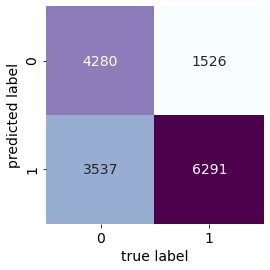

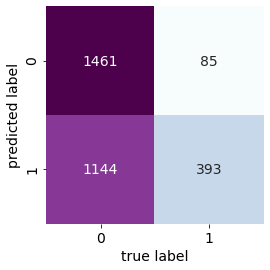

In [431]:
y_train = upsampled.Revenue
x_train = upsampled.drop('Revenue', axis=1)
upsampled = classifier.fit(x_train, y_train)
upsampled_pred_train = upsampled.predict(x_train)
upsampled_pred = upsampled.predict(x_test)

print('Report for Training Set')
f1_kappa_cm_report(y_train, upsampled_pred_train, class_names=None)
print('--------------------------------------------------------')
print('Report for Test Set')
f1_kappa_cm_report(y_test, upsampled_pred, class_names = None)

In [433]:
# still using our separated classes true and not_true from above

# downsample majority
not_true_downsampled = resample(not_true,
                                replace = False, # sample without replacement
                                n_samples = len(true), # match minority n
                                random_state = 43) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_true_downsampled, true])

# checking counts
downsampled.Revenue.value_counts()

1    1430
0    1430
Name: Revenue, dtype: int64

Report for Training Set
F1 Score: 0.68
Kappa Score: 0.37
              precision    recall  f1-score   support

           0       0.75      0.56      0.64      1430
           1       0.65      0.81      0.72      1430

    accuracy                           0.68      2860
   macro avg       0.70      0.68      0.68      2860
weighted avg       0.70      0.68      0.68      2860

Confusion Matrix: 
 [[ 800  630]
 [ 272 1158]]
--------------------------------------------------------
Report for Test Set
F1 Score: 0.55
Kappa Score: 0.20
              precision    recall  f1-score   support

           0       0.94      0.56      0.70      2605
           1       0.25      0.81      0.39       478

    accuracy                           0.60      3083
   macro avg       0.60      0.69      0.55      3083
weighted avg       0.84      0.60      0.65      3083

Confusion Matrix: 
 [[1463 1142]
 [  89  389]]


(0.5455651636435654, 0.19765667232756257)

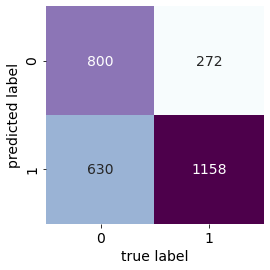

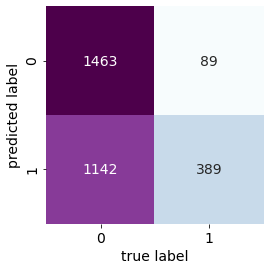

In [434]:
y_train = downsampled.Revenue
x_train = downsampled.drop('Revenue', axis=1)
downsampled = classifier.fit(x_train, y_train)
downsampled_pred_train = downsampled.predict(x_train)
downsampled_pred = downsampled.predict(x_test)

print('Report for Training Set')
f1_kappa_cm_report(y_train, downsampled_pred_train, class_names=None)
print('--------------------------------------------------------')
print('Report for Test Set')
f1_kappa_cm_report(y_test, downsampled_pred, class_names=None)

### 4.2 Mixed Naive Bayes (Gaussian + Categorical Approach)

In [465]:
data_frame_os

,ProductRelated_Duration,ProductRelatedAve,BounceRates,ExitRates,SpecialDay,Month,Region,VisitorType,Weekend,Revenue
0,0.000000,0.000000,0.200000,0.200000,0.0,0,1,0,0,False
1,64.000000,32.000000,0.000000,0.100000,0.0,0,1,0,0,False
2,0.000000,0.000000,0.200000,0.200000,0.0,0,9,0,0,False
3,2.666667,1.333333,0.050000,0.140000,0.0,0,2,0,0,False
4,627.500000,62.750000,0.020000,0.050000,0.0,0,1,0,1,False
...,...,...,...,...,...,...,...,...,...,...
12325,1783.791667,33.656447,0.007143,0.029031,0.0,9,1,0,1,False
12326,465.750000,93.150000,0.000000,0.021333,0.0,7,1,0,1,False
12327,184.250000,30.708333,0.083333,0.086667,0.0,7,1,0,1,False
12328,346.000000,23.066667,0.000000,0.021053,0.0,7,3,0,0,False


In [494]:
# ----- Prepare data -----
# Select data for modeling

x_g = data_frame_os[['ProductRelated_Duration', 'ProductRelatedAve', 'BounceRates', 'ExitRates', 'SpecialDay']]
x_c = data_frame_os[['Month', 'Region', 'VisitorType', 'Weekend']]
y = data_frame_os[['Revenue']].values

# Combine all variables into one array
X=np.c_[x_g, x_c]

# Create training and testing samples
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

# ----- Fit the two models -----
# Now use the Gaussian model for continuous independent variable and 
model_G = GaussianNB()
clf_G = model_G.fit(X_train[:,0:5], y_train)
# Categorical model for discrete independent variable
model_C = CategoricalNB()
clf_C = model_C.fit(X_train[:,5:9], y_train)

# ----- Get probability predictions from each model -----
# On training data
G_train_probas = model_G.predict_proba(X_train[:,0:5])
C_train_probas = model_C.predict_proba(X_train[:,5:9])
# And on testing data
G_test_probas = model_G.predict_proba(X_test[:,0:5])
C_test_probas = model_C.predict_proba(X_test[:,5:9])

# Combine probability prediction for class=1 from both models into a 2D array
X_new_train = np.c_[(G_train_probas[:,1], C_train_probas[:,1])] # Train
X_new_test = np.c_[(G_test_probas[:,1], C_test_probas[:,1])] # Test

# ----- Fit Gaussian model on the X_new -----
model = GaussianNB()
clf = model.fit(X_new_train, y_train)

# Predict class labels on a test data
y_pred_train = model.predict(X_new_train)
y_pred_test = model.predict(X_new_test)

--------------------------------------------------------
Report for Training
F1 Score: 0.50
Kappa Score: -0.00
              precision    recall  f1-score   support

       False       0.85      0.84      0.85      7828
        True       0.15      0.15      0.15      1419

    accuracy                           0.74      9247
   macro avg       0.50      0.50      0.50      9247
weighted avg       0.74      0.74      0.74      9247

Confusion Matrix: 
 [[6614 1214]
 [1204  215]]
--------------------------------------------------------
Report for Testing
F1 Score: 0.52
Kappa Score: 0.03
              precision    recall  f1-score   support

       False       0.85      0.86      0.85      2594
        True       0.19      0.17      0.18       489

    accuracy                           0.75      3083
   macro avg       0.52      0.51      0.52      3083
weighted avg       0.74      0.75      0.75      3083

Confusion Matrix: 
 [[2230  364]
 [ 406   83]]


(0.515061446944812, 0.03047226040852402)

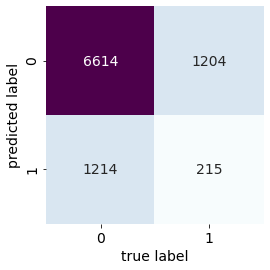

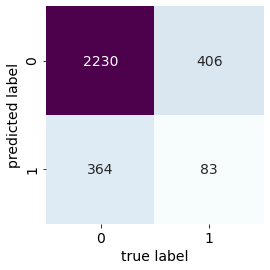

In [495]:
print('--------------------------------------------------------')
print("Report for Training")
y_pred_train = prediction(classifier, x_train)
f1_kappa_cm_report(y_train, y_pred_train, class_names=None)
print('--------------------------------------------------------')
print("Report for Testing")
y_pred_test = prediction(classifier, x_test)
f1_kappa_cm_report(y_test, y_pred_test, class_names=None)